In [1]:
from tsai.all import *
import sklearn.metrics as skm

computer_setup()

c:\Users\lucki\anaconda3\envs\stylegan\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


os              : Windows-10-10.0.22621-SP0
python          : 3.8.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.9.1+cu111
device          : 1 gpu (['NVIDIA GeForce RTX 2070 SUPER'])
cpu cores       : 8
threads per cpu : 2
RAM             : 31.92 GB
GPU memory      : [8.0] GB


### Resteaze Data

In [2]:
# Read the data
data = pd.read_csv('final_processed.csv', index_col=0)

# select the columns
data = data.interpolate()[[
    'ledGreen', 'accelerometer', 'gyroscope', 'bpm', 'breathingrate', 'hr',
    'sleep_state'
]].dropna()

# drop rows where 'hr' column have values starting with '['
data = data[~data['hr'].str.startswith('[', na=False)]

In [3]:
data.reset_index(drop=True, inplace=True)

In [4]:
df = data.copy()

In [5]:
df

,ledGreen,accelerometer,gyroscope,bpm,breathingrate,hr,sleep_state
0,1.428279,4190.530336,265.067916,34.883721,0.166667,8.79517,0
1,3.933569,4188.984364,263.579210,34.902132,0.166667,9.444221,0
2,6.364565,4193.186126,259.126953,34.920543,0.166667,10.60804,0
3,8.620646,4197.390168,254.879928,34.938953,0.166667,12.624369,0
4,10.742956,4201.596482,250.848560,34.957364,0.166667,15.443452,0
...,...,...,...,...,...,...,...
15755639,-11.354944,4051.366436,360.151357,75.000000,0.208333,55.93142373063932,0
15755640,-11.523757,4049.565532,342.725109,75.000000,0.208333,56.45873227571159,0
15755641,-11.236864,4047.766051,325.338285,75.000000,0.208333,55.81281276735538,0
15755642,-10.867185,4057.986631,317.401166,75.000000,0.208333,54.71646993694944,0


## TSData preparation

In [ ]:
# load the npy files
X = np.load('X.npy')
y = np.load('y.npy')

In [9]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder


scaler = MinMaxScaler()
le = LabelEncoder()

X = scaler.fit_transform(df[['ledGreen', 'accelerometer', 'gyroscope', 'bpm', 'breathingrate', 'hr']])
X = X.reshape(len(X), 1, -1)
y = le.fit_transform(df['sleep_state'])

X.shape, y.shape

((15755644, 1, 6), (15755644,))

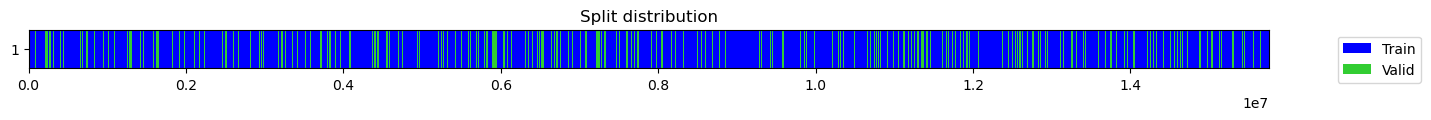

((#12604516) [7007909,15585773,2314207,8903328,6928347,817222,12369345,8990243,14506760,11033194...],
 (#3151128) [2937297,7246212,2123974,12626611,14978977,4809930,6113187,6513708,5164686,9231196...])

In [11]:
splits = get_splits(y,
                    valid_size=.2,
                    stratify=True,
                    random_state=23,
                    shuffle=True)
splits

In [12]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

In [13]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

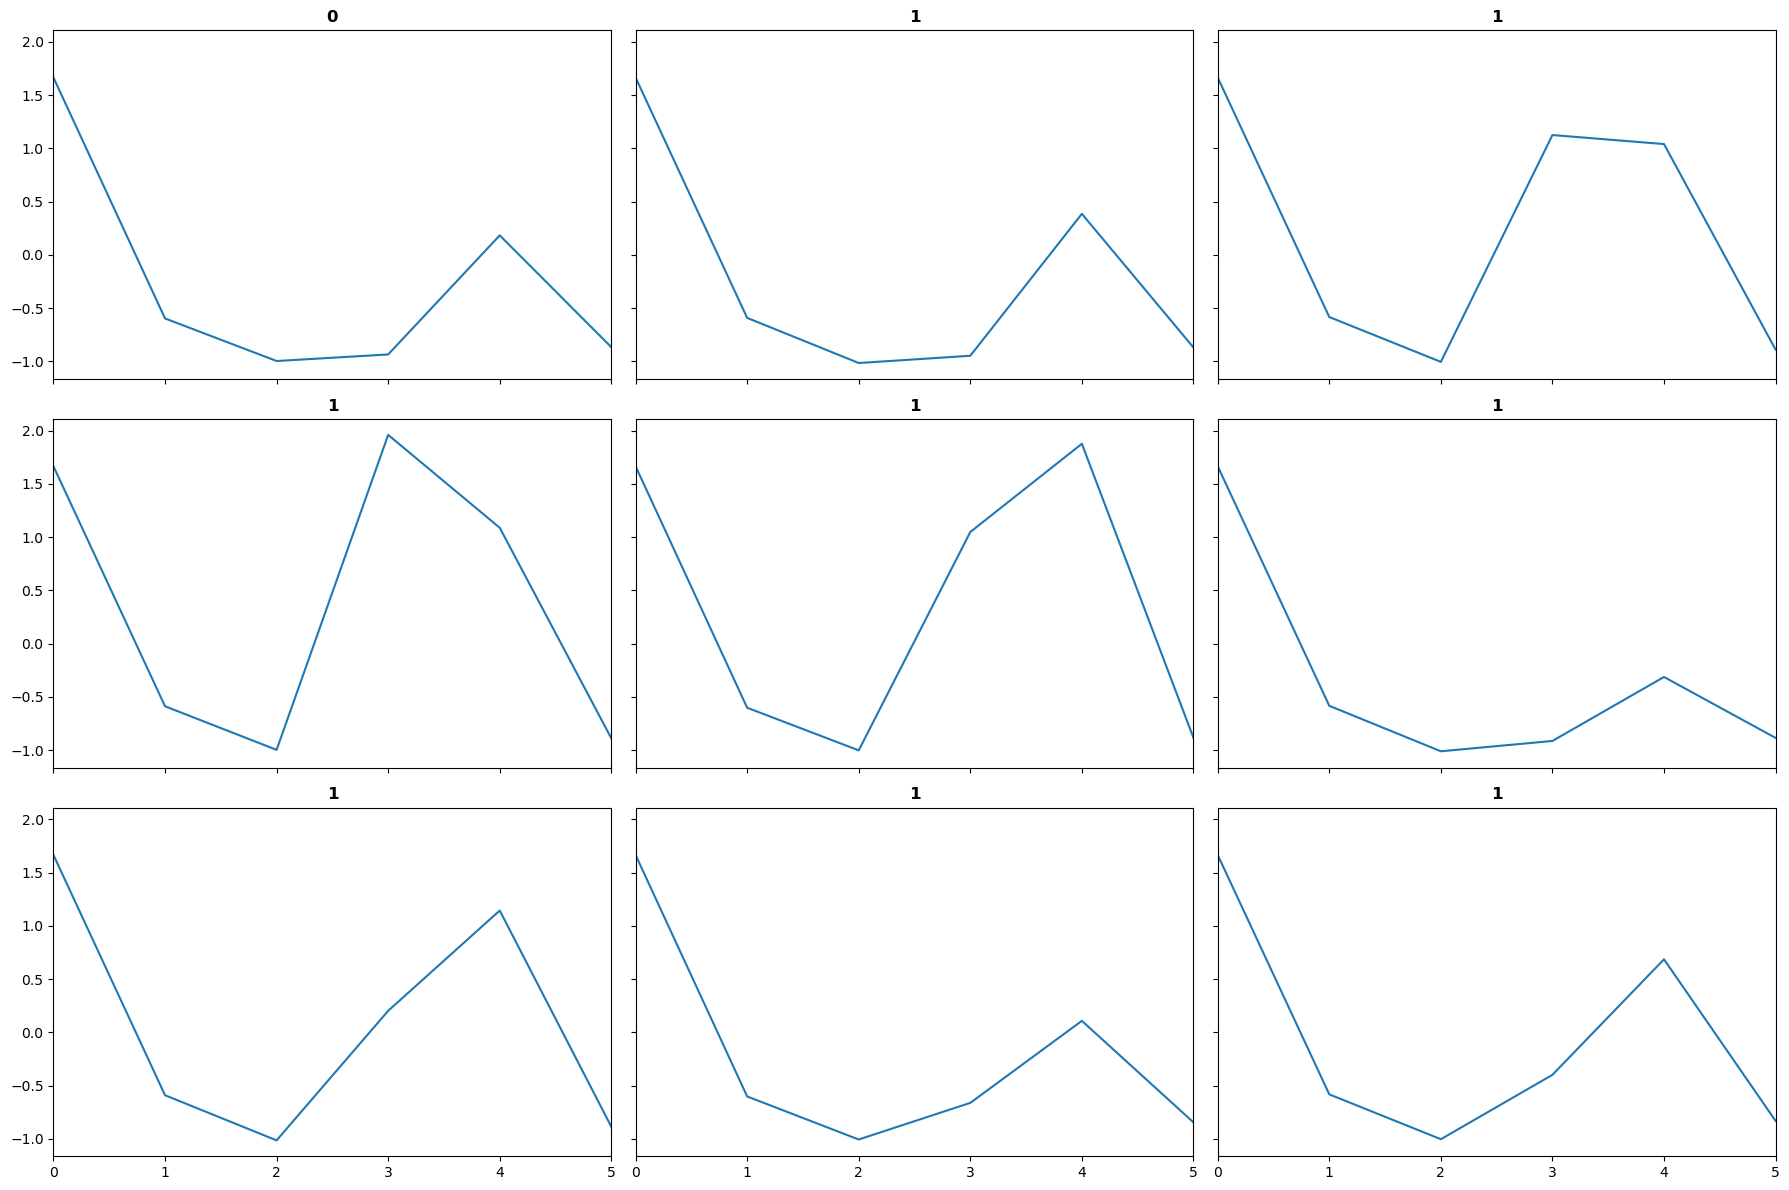

In [14]:
dls.show_batch(sharey=True)

## Build learner

In [15]:
# model = InceptionTime(
#     dls.vars,
#     dls.c,
# )
# learn = Learner(dls, model, metrics=accuracy)
# learn.save('stage0')

In [16]:
archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}),
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}),
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]


for i, (arch, k) in enumerate(archs):
    print(f'arch: {arch.__name__}')

arch: FCN
arch: ResNet
arch: xresnet1d34
arch: ResCNN
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM_FCN
arch: LSTM_FCN
arch: InceptionTime
arch: XceptionTime
arch: OmniScaleCNN
arch: mWDN


In [17]:
model = create_model(LSTM_FCN, dls=dls, **{'shuffle': False})


In [18]:
learn = Learner(dls, model, metrics=accuracy)


## LR find

In [19]:
# learn.load('stage0')
# learn.lr_find()

In [20]:
learn.fit_one_cycle(25, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.471210,0.536473,0.744649,34:04
1,0.430040,0.452746,0.793514,34:19
2,0.400322,0.420922,0.811076,34:38
3,0.382865,0.460020,0.784783,35:05
4,0.385300,0.437142,0.798876,34:40
5,0.380510,0.443665,0.798533,34:37
6,0.379135,0.509314,0.756607,34:42
7,0.377860,0.431324,0.803961,34:29
8,0.360764,0.373103,0.835318,34:41
9,0.362533,0.424252,0.806684,34:59


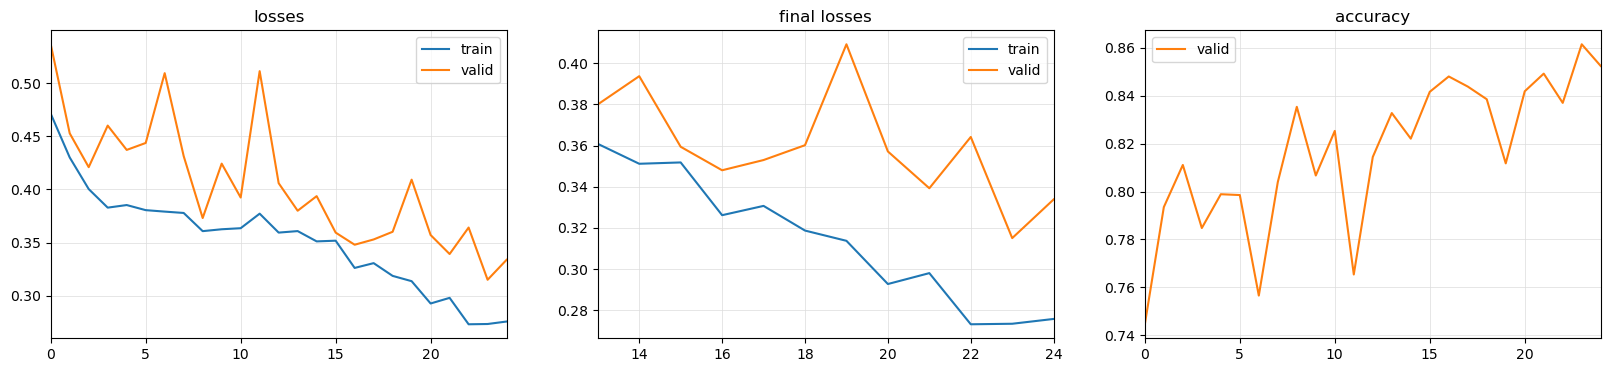

In [21]:
learn.plot_metrics()

In [22]:
learn.save('LSTM_FCN_stage1')

Path('models/LSTM_FCN_stage1.pth')

In [28]:
learn.save_all(path='export',
               dls_fname='dls',
               model_fname='LSMT_FCN',
               learner_fname='learner')

## Inferece


In [23]:
# learn = load_learner_all(path='export',
#                          dls_fname='dls',
#                          model_fname='model',
#                          learner_fname='learner')


dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:128, vars:1, len:6, device=cuda:0, dtype=torch.float32),
 TensorCategory([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
         1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
         0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 1, 1, 1, 1], device='cuda:0'))

In [24]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl,
                                                           with_decoded=True)
valid_probas, valid_targets, valid_preds

(tensor([[0.0058, 0.9942],
         [0.0145, 0.9855],
         [0.0970, 0.9030],
         ...,
         [0.8895, 0.1105],
         [0.0726, 0.9274],
         [0.2027, 0.7973]]),
 tensor([1, 1, 0,  ..., 0, 1, 1]),
 tensor([1, 1, 1,  ..., 0, 1, 1]))

In [30]:
(valid_targets == valid_preds).float().mean()

tensor(0.8523)

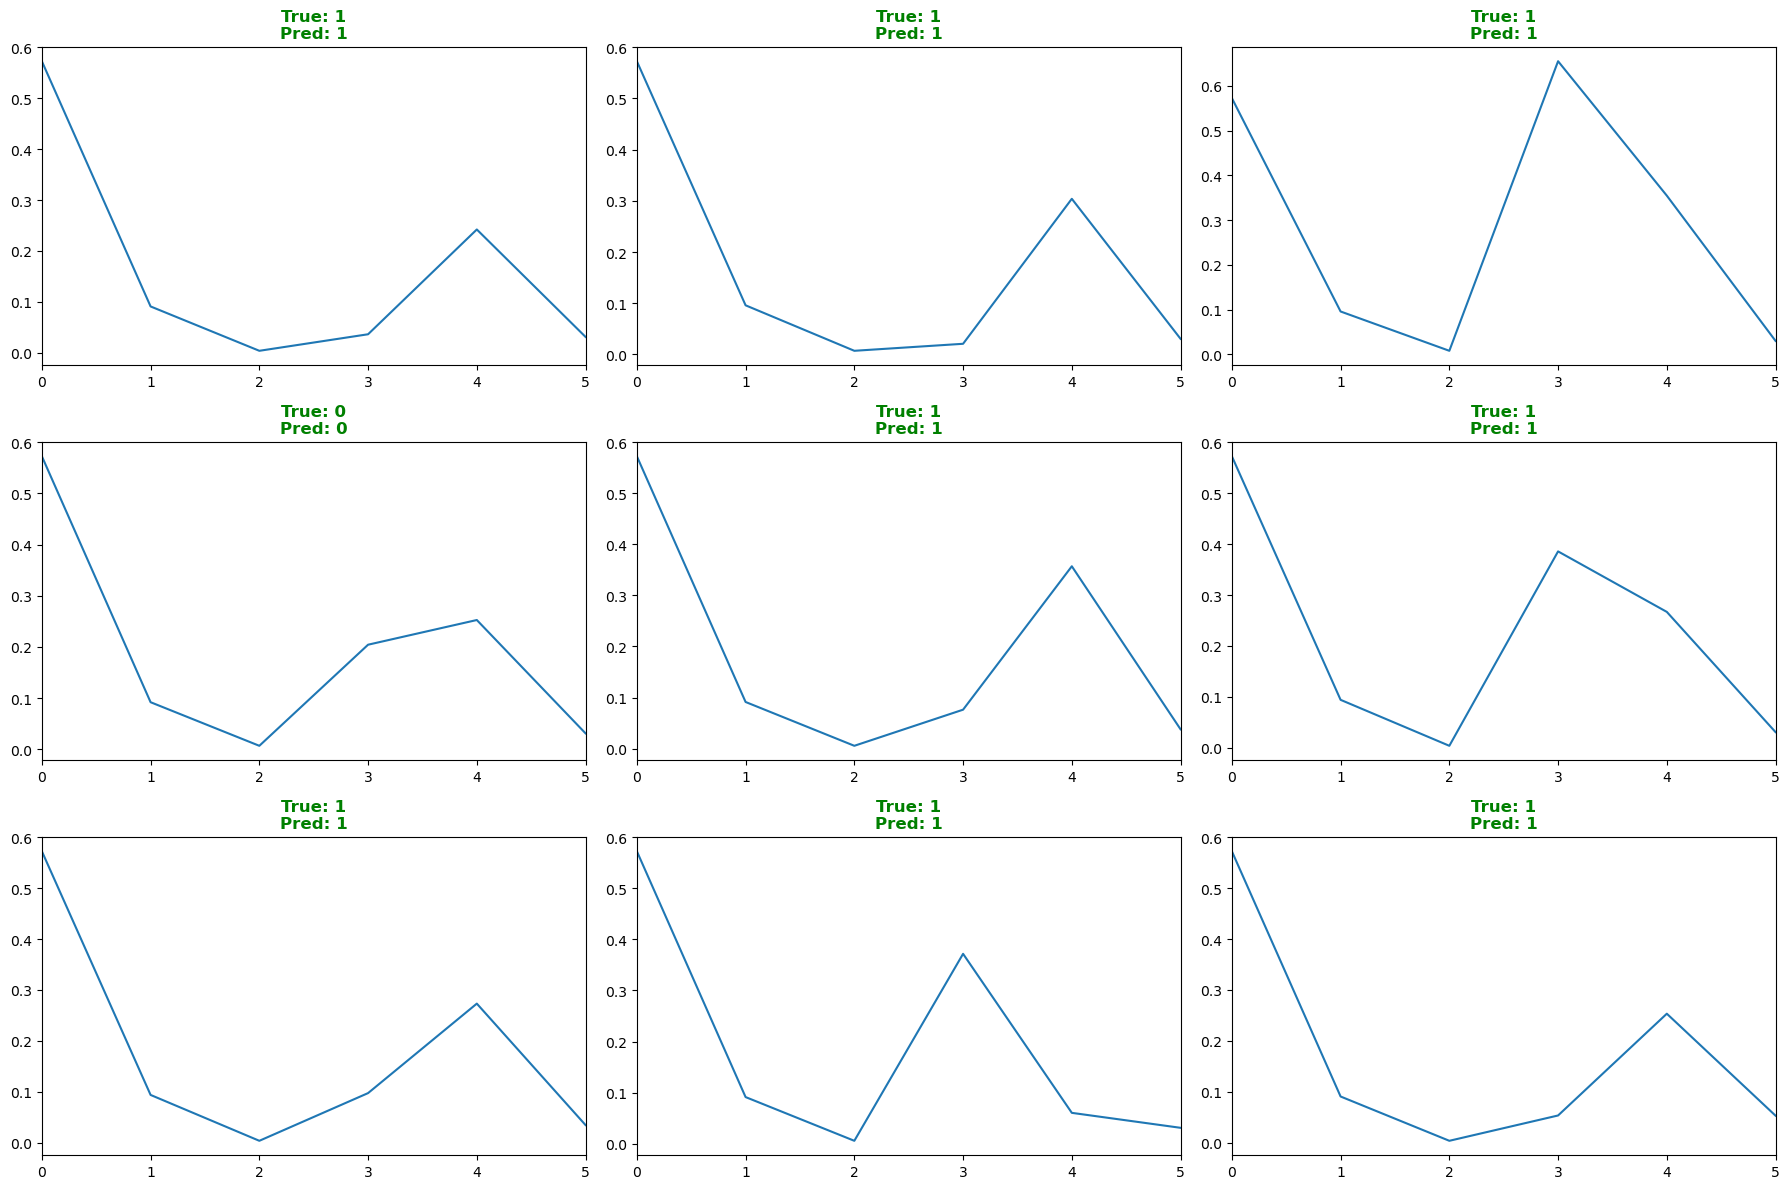

In [25]:
learn.show_results()


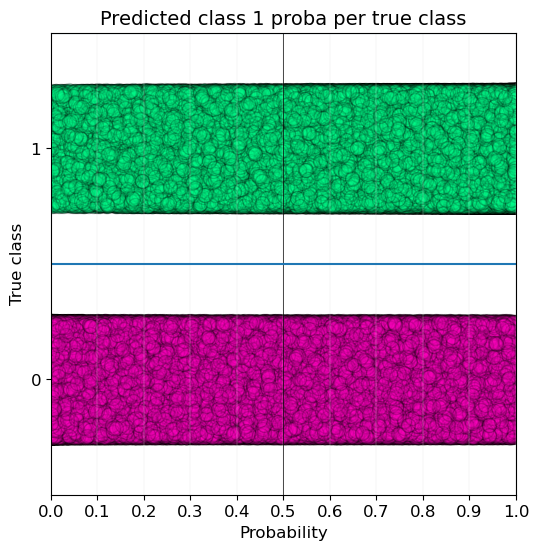

In [26]:
learn.show_probas()


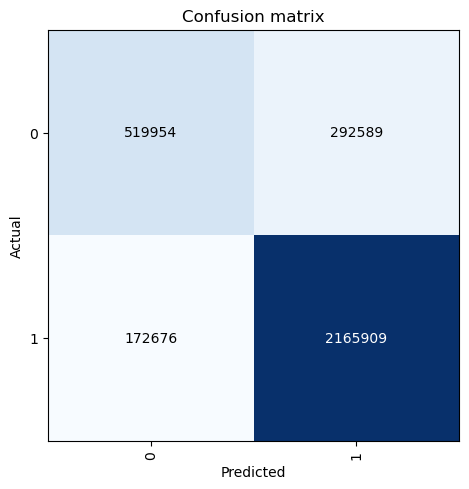

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [31]:
interp.most_confused(min_val=3)

[(0, 1, 292589), (1, 0, 172676)]

In [29]:
print(f'accuracy: {skm.accuracy_score(valid_targets, valid_preds):10.6f}')

accuracy:   0.852350


# inference on unseen data

In [ ]:
X_test, y_test = None, None

In [ ]:
# Labelled test data
test_ds = valid_dl.dataset.add_test(
    X_test, y_test)  # In this case I'll use X and y, but this would be your test data
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl,
                                                        with_decoded=True,
                                                        save_preds=None,
                                                        save_targs=None)
test_probas, test_targets, test_preds


In [ ]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')

#### If unlabelled data

In [ ]:
# Unlabelled data
test_ds = dls.dataset.add_test(X)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas
